# Excel Report Generation for Financial Statements

This notebook demonstrates the comprehensive Excel report generation functionality for creating financial statements, reconciliation reports, and metrics dashboards from simulation results.

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directories to path
sys.path.insert(0, str(Path().absolute().parent.parent))

from ergodic_insurance.src.config import ManufacturerConfig
from ergodic_insurance.src.config_v2 import InsuranceConfig, ExcelReportConfig
from ergodic_insurance.src.manufacturer import WidgetManufacturer
from ergodic_insurance.src.claim_generator import ClaimGenerator
from ergodic_insurance.src.insurance import InsurancePolicy
from ergodic_insurance.src.excel_reporter import ExcelReporter
from ergodic_insurance.src.financial_statements import (
    FinancialStatementGenerator,
    FinancialStatementConfig
)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Setup complete!")

c:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits\ergodic_insurance\src\excel_reporter.py:46: UserWarning: XlsxWriter not available. Some formatting features may be limited.
  warnings.warn("XlsxWriter not available. Some formatting features may be limited.")


Setup complete!


## 2. Run Simulation with Insurance Claims

In [2]:
# Configure and create manufacturer
manufacturer_config = ManufacturerConfig(
    initial_assets=10_000_000,
    asset_turnover_ratio=0.5,
    operating_margin=0.08,
    tax_rate=0.25,
    retention_ratio=0.7
)

manufacturer = WidgetManufacturer(manufacturer_config)

# Create claim generator with appropriate parameters
# Note: ClaimGenerator doesn't have separate attritional/large loss configs
# We'll use moderate frequency and severity for demonstration
claim_generator = ClaimGenerator(
    frequency=5.3,  # Expected claims per year (combines attritional + large)
    severity_mean=500_000,  # Mean claim size
    severity_std=750_000,  # Standard deviation of claim size
    seed=42  # For reproducibility
)

# Configure insurance with layers
from ergodic_insurance.src.insurance import InsuranceLayer

# Create a single insurance layer with $5M limit above $100K attachment
insurance_layer = InsuranceLayer(
    attachment_point=100_000,  # Deductible essentially
    limit=5_000_000,  # Coverage limit
    rate=0.02  # Premium as percentage of limit
)

insurance = InsurancePolicy(
    layers=[insurance_layer],
    deductible=100_000
)

print("Configuration complete!")

Configuration complete!


In [3]:
# Run 10-year simulation
np.random.seed(42)
simulation_years = 10

# Generate all claims for the simulation period
all_claims = claim_generator.generate_claims(simulation_years)

# Group claims by year
claims_by_year = {}
for claim in all_claims:
    if claim.year not in claims_by_year:
        claims_by_year[claim.year] = []
    claims_by_year[claim.year].append(claim.amount)

for year in range(simulation_years):
    # Get claims for this year
    year_claims = claims_by_year.get(year, [])
    total_claims = sum(year_claims)
    
    # Process insurance claims if there are any
    if total_claims > 0:
        company_payment, insurance_payment = insurance.process_claim(total_claims)
    else:
        company_payment, insurance_payment = 0, 0
    
    # Calculate insurance premium
    insurance_premium = insurance.calculate_premium()
    
    # Run annual step
    metrics = manufacturer.step(
        working_capital_pct=0.2,
        letter_of_credit_rate=0.015,
        growth_rate=0.03
    )
    
    # Deduct insurance costs and claim payments from company
    manufacturer.assets -= insurance_premium + company_payment
    manufacturer.equity -= insurance_premium + company_payment

print(f"Simulation complete! Final equity: ${manufacturer.equity:,.0f}")

Simulation complete! Final equity: $10,164,234


## 3. Generate Financial Statements

In [4]:
# Create financial statement generator
# We need to pass manufacturer_data directly since the manufacturer object
# doesn't have an initial_assets attribute at the top level
stmt_config = FinancialStatementConfig(
    currency_symbol="$",
    decimal_places=0,
    include_yoy_change=True
)

# Create manufacturer data dictionary with the required structure
manufacturer_data = {
    "metrics_history": manufacturer.metrics_history,
    "initial_assets": manufacturer.config.initial_assets,
    "config": manufacturer.config
}

stmt_generator = FinancialStatementGenerator(
    manufacturer_data=manufacturer_data,
    config=stmt_config
)

print(f"Years available: {stmt_generator.years_available}")

Years available: 10


### 3.1 Balance Sheet

In [5]:
# Generate balance sheet for the last year
last_year = stmt_generator.years_available - 1
balance_sheet = stmt_generator.generate_balance_sheet(last_year)

# Display key items
print("BALANCE SHEET - Year", last_year)
print("=" * 50)
display(balance_sheet[balance_sheet['Item'].str.contains('TOTAL|ASSETS|LIABILITIES|EQUITY', na=False)])

BALANCE SHEET - Year 9


,Item,Year 9,YoY Change %,Type
0,ASSETS,,,
16,TOTAL ASSETS,"10,364,233.65",0.4%,total
19,LIABILITIES,,,
30,TOTAL LIABILITIES,0,,total
33,EQUITY,,,
36,TOTAL EQUITY,"10,364,233.65",0.4%,total
39,TOTAL LIABILITIES + EQUITY,"10,364,233.65",,total


### 3.2 Income Statement

In [6]:
# Generate income statement
income_statement = stmt_generator.generate_income_statement(last_year)

# Display key items
print("INCOME STATEMENT - Year", last_year)
print("=" * 50)
display(income_statement[income_statement['Item'].str.contains('REVENUE|INCOME|NET', na=False)])

INCOME STATEMENT - Year 9


,Item,Year 9,Unit,Type,Year 8
0,REVENUE,,,,
9,OPERATING INCOME,"557,146.53",,subtotal,
11,OTHER INCOME (EXPENSES),,,,
17,INCOME BEFORE TAXES,"557,146.53",,subtotal,
21,NET INCOME,"417,859.90",,total,


### 3.3 Cash Flow Statement

In [7]:
# Generate cash flow statement
cash_flow = stmt_generator.generate_cash_flow_statement(last_year, method='indirect')

# Display summary
print("CASH FLOW STATEMENT - Year", last_year)
print("=" * 50)
display(cash_flow[cash_flow['Item'].str.contains('ACTIVITIES|NET CHANGE', na=False)])

CASH FLOW STATEMENT - Year 9


,Item,Year 9,Type
0,OPERATING ACTIVITIES,,
8,INVESTING ACTIVITIES,,
12,FINANCING ACTIVITIES,,
15,NET CHANGE IN CASH,"913,440.98",total


### 3.4 Reconciliation Report

In [8]:
# Generate reconciliation report
reconciliation = stmt_generator.generate_reconciliation_report(last_year)

print("RECONCILIATION REPORT - Year", last_year)
print("=" * 50)
display(reconciliation)

RECONCILIATION REPORT - Year 9


,Check,Value,Expected,Type
0,BALANCE SHEET RECONCILIATION,,,
1,Assets,"10,364,233.65",,
2,Liabilities + Equity,"10,364,233.65",,
3,Difference,0.00,,
4,Status,BALANCED,,status
5,,,,
6,NET ASSETS RECONCILIATION,,,
7,Reported Net Assets,"10,364,233.65",,
8,Calculated (Assets - Restricted),"10,364,233.65",,
9,Difference,0.00,,


## 4. Generate Excel Reports

### 4.1 Basic Excel Report

In [9]:
# Create output directory
output_dir = Path("./excel_reports")
output_dir.mkdir(exist_ok=True)

# Save basic report with pandas
basic_file = output_dir / "basic_financial_statements.xlsx"

with pd.ExcelWriter(basic_file, engine='openpyxl') as writer:
    balance_sheet.to_excel(writer, sheet_name='Balance Sheet', index=False)
    income_statement.to_excel(writer, sheet_name='Income Statement', index=False)
    cash_flow.to_excel(writer, sheet_name='Cash Flow', index=False)
    reconciliation.to_excel(writer, sheet_name='Reconciliation', index=False)

print(f"Basic report saved to: {basic_file}")

Basic report saved to: excel_reports\basic_financial_statements.xlsx


### 4.2 Comprehensive Excel Report with Formatting

In [10]:
# Configure Excel reporter
# Note: ExcelReportConfig expects a string path, but ExcelReporter tries to use it as Path
# We'll work around this by creating the directory first
output_dir.mkdir(exist_ok=True)

excel_config = ExcelReportConfig(
    output_path=str(output_dir),  # Convert Path to string as required by config
    include_balance_sheet=True,
    include_income_statement=True,
    include_cash_flow=True,
    include_reconciliation=True,
    include_metrics_dashboard=True,
    include_pivot_data=True,
    engine="auto",
    currency_format="$#,##0",
    decimal_places=0
)

# Patch the config's output_path to be a Path object for ExcelReporter
# This is a workaround for the type mismatch
from pathlib import Path as PathType
excel_config_dict = excel_config.model_dump()
excel_config_dict['output_path'] = PathType(excel_config_dict['output_path'])

# Create reporter with patched config
from ergodic_insurance.src.config_v2 import ExcelReportConfig as ConfigClass
patched_config = type('ExcelReportConfig', (), excel_config_dict)()
for key, value in excel_config_dict.items():
    setattr(patched_config, key, value)

reporter = ExcelReporter(patched_config)

# Add the missing initial_assets attribute to manufacturer
# This is a workaround for the FinancialStatementGenerator compatibility issue
manufacturer.initial_assets = manufacturer.config.initial_assets

# Generate comprehensive report
comprehensive_file = reporter.generate_trajectory_report(
    manufacturer,
    "comprehensive_financial_report.xlsx",
    title="Widget Manufacturing Company - Financial Analysis"
)

print(f"Comprehensive report saved to: {comprehensive_file}")
print(f"Report engine used: {reporter.engine}")

Comprehensive report saved to: excel_reports\comprehensive_financial_report.xlsx
Report engine used: openpyxl


## 5. Multi-Year Analysis

In [11]:
# Create multi-year summary
metrics_summary = []

for year in range(stmt_generator.years_available):
    metrics = manufacturer.metrics_history[year]
    summary = {
        'Year': year,
        'Assets': metrics.get('assets', 0),
        'Equity': metrics.get('equity', 0),
        'Revenue': metrics.get('revenue', 0),
        'Operating Income': metrics.get('operating_income', 0),
        'Net Income': metrics.get('net_income', 0),
        'ROE %': metrics.get('roe', 0) * 100,
        'ROA %': metrics.get('roa', 0) * 100,
        'Operating Margin %': metrics.get('operating_margin', 0) * 100
    }
    metrics_summary.append(summary)

multi_year_df = pd.DataFrame(metrics_summary)

# Calculate growth rates
multi_year_df['Revenue Growth %'] = multi_year_df['Revenue'].pct_change() * 100
multi_year_df['Asset Growth %'] = multi_year_df['Assets'].pct_change() * 100

display(multi_year_df)

,Year,Assets,Equity,Revenue,Operating Income,Net Income,ROE %,ROA %,Operating Margin %,Revenue Growth %,Asset Growth %
0,0,"10,190,909.09","10,190,909.09","5,248,318.18","419,865.45","314,899.09",3.09,3.09,8.00,NaN,NaN
1,1,"10,186,832.36","10,186,832.36","5,403,605.22","432,288.42","324,216.31",3.18,3.18,8.00,2.96,-0.04
2,2,"10,187,987.45","10,187,987.45","5,566,344.48","445,307.56","333,980.67",3.28,3.28,8.00,3.01,0.01
3,3,"10,194,606.63","10,194,606.63","5,737,059.79","458,964.78","344,223.59",3.38,3.38,8.00,3.07,0.06
4,4,"10,206,937.93","10,206,937.93","5,916,319.26","473,305.54","354,979.16",3.48,3.48,8.00,3.12,0.12
5,5,"10,225,246.45","10,225,246.45","6,104,739.50","488,379.16","366,284.37",3.58,3.58,8.00,3.18,0.18
6,6,"10,249,815.74","10,249,815.74","6,302,990.25","504,239.22","378,179.42",3.69,3.69,8.00,3.25,0.24
7,7,"10,280,949.34","10,280,949.34","6,511,799.52","520,943.96","390,707.97",3.80,3.80,8.00,3.31,0.30
8,8,"10,318,972.44","10,318,972.44","6,731,959.26","538,556.74","403,917.56",3.91,3.91,8.00,3.38,0.37
9,9,"10,364,233.65","10,364,233.65","6,964,331.68","557,146.53","417,859.90",4.03,4.03,8.00,3.45,0.44


## 6. Visualizations

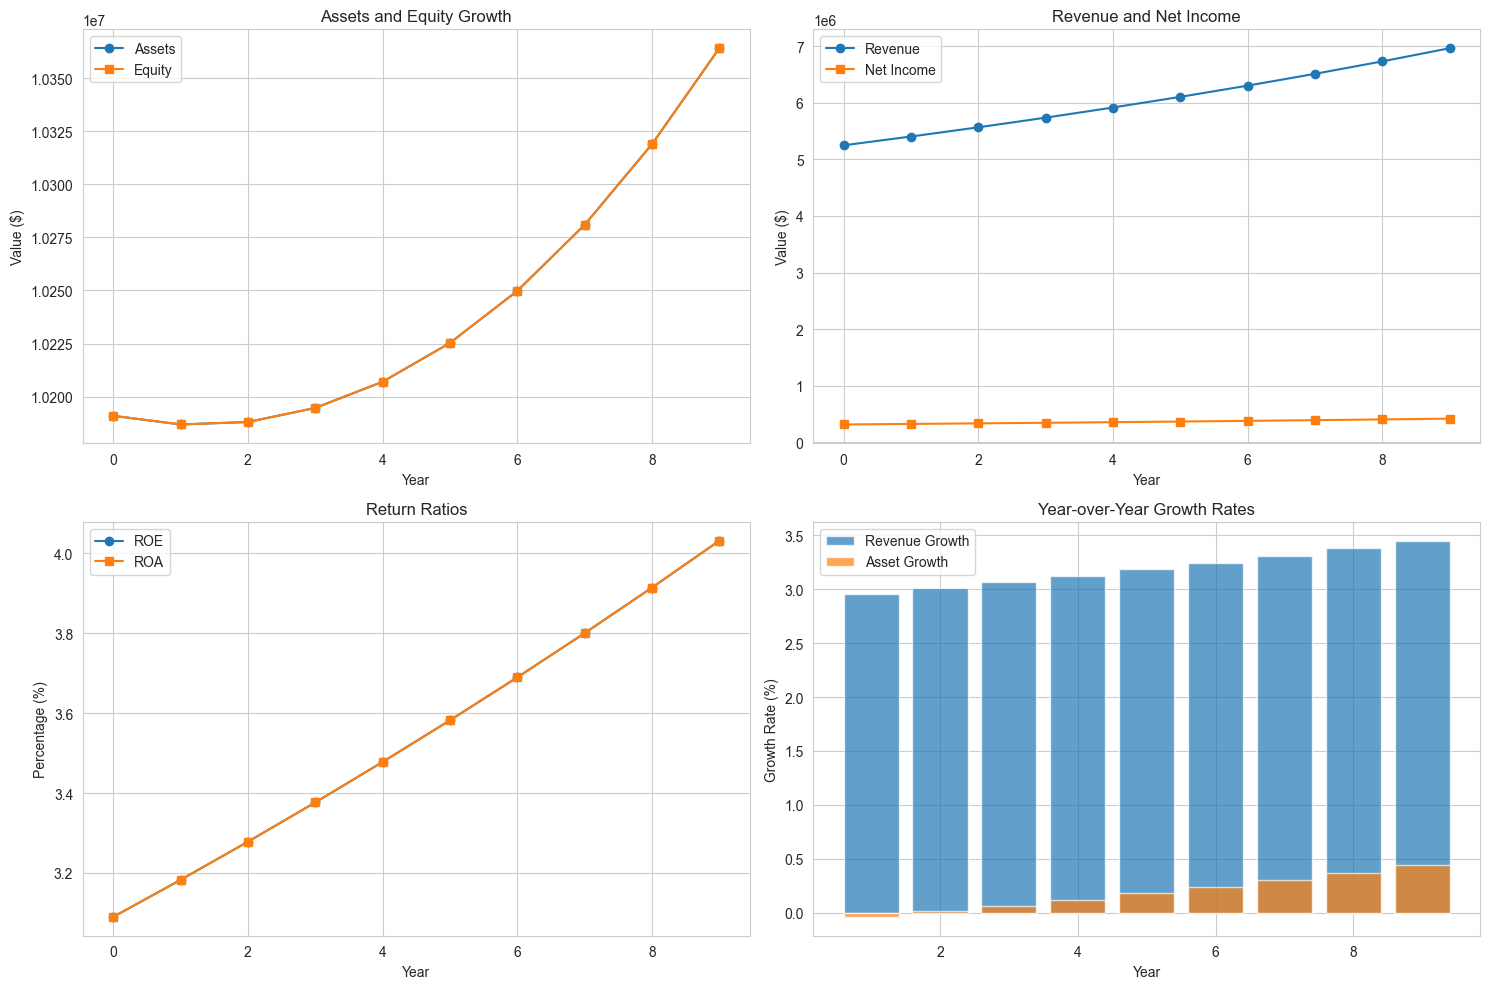

In [12]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Asset and Equity Growth
axes[0, 0].plot(multi_year_df['Year'], multi_year_df['Assets'], marker='o', label='Assets')
axes[0, 0].plot(multi_year_df['Year'], multi_year_df['Equity'], marker='s', label='Equity')
axes[0, 0].set_title('Assets and Equity Growth')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Value ($)')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Revenue and Income
axes[0, 1].plot(multi_year_df['Year'], multi_year_df['Revenue'], marker='o', label='Revenue')
axes[0, 1].plot(multi_year_df['Year'], multi_year_df['Net Income'], marker='s', label='Net Income')
axes[0, 1].set_title('Revenue and Net Income')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Value ($)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Financial Ratios
axes[1, 0].plot(multi_year_df['Year'], multi_year_df['ROE %'], marker='o', label='ROE')
axes[1, 0].plot(multi_year_df['Year'], multi_year_df['ROA %'], marker='s', label='ROA')
axes[1, 0].set_title('Return Ratios')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Percentage (%)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Growth Rates
axes[1, 1].bar(multi_year_df['Year'][1:], multi_year_df['Revenue Growth %'][1:], 
               alpha=0.7, label='Revenue Growth')
axes[1, 1].bar(multi_year_df['Year'][1:], multi_year_df['Asset Growth %'][1:], 
               alpha=0.7, label='Asset Growth')
axes[1, 1].set_title('Year-over-Year Growth Rates')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Growth Rate (%)')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## 7. Summary Statistics

In [13]:
# Calculate summary statistics
print("SUMMARY STATISTICS")
print("=" * 50)
print(f"Initial Assets: ${multi_year_df['Assets'].iloc[0]:,.0f}")
print(f"Final Assets: ${multi_year_df['Assets'].iloc[-1]:,.0f}")
print(f"Total Asset Growth: {(multi_year_df['Assets'].iloc[-1] / multi_year_df['Assets'].iloc[0] - 1) * 100:.1f}%")
print(f"CAGR (Assets): {((multi_year_df['Assets'].iloc[-1] / multi_year_df['Assets'].iloc[0]) ** (1/(len(multi_year_df)-1)) - 1) * 100:.1f}%")
print()
print(f"Average Revenue: ${multi_year_df['Revenue'].mean():,.0f}")
print(f"Average Net Income: ${multi_year_df['Net Income'].mean():,.0f}")
print(f"Average ROE: {multi_year_df['ROE %'].mean():.1f}%")
print(f"Average ROA: {multi_year_df['ROA %'].mean():.1f}%")
print(f"Average Operating Margin: {multi_year_df['Operating Margin %'].mean():.1f}%")

SUMMARY STATISTICS
Initial Assets: $10,190,909
Final Assets: $10,364,234
Total Asset Growth: 1.7%
CAGR (Assets): 0.2%

Average Revenue: $6,048,747
Average Net Income: $362,925
Average ROE: 3.5%
Average ROA: 3.5%
Average Operating Margin: 8.0%


## 8. Export Multi-Year Analysis to Excel

In [14]:
# Save multi-year analysis
analysis_file = output_dir / "multi_year_analysis.xlsx"

with pd.ExcelWriter(analysis_file, engine='openpyxl') as writer:
    # Multi-year summary
    multi_year_df.to_excel(writer, sheet_name='Multi-Year Summary', index=False)
    
    # Add each year's statements
    for year in range(min(5, stmt_generator.years_available)):  # Limit to 5 years
        bs = stmt_generator.generate_balance_sheet(year)
        bs.to_excel(writer, sheet_name=f'BS Year {year}', index=False)
    
    # Summary statistics
    summary_stats = pd.DataFrame({
        'Metric': ['Initial Assets', 'Final Assets', 'Total Growth %', 'CAGR %', 
                  'Avg Revenue', 'Avg Net Income', 'Avg ROE %', 'Avg ROA %'],
        'Value': [
            multi_year_df['Assets'].iloc[0],
            multi_year_df['Assets'].iloc[-1],
            (multi_year_df['Assets'].iloc[-1] / multi_year_df['Assets'].iloc[0] - 1) * 100,
            ((multi_year_df['Assets'].iloc[-1] / multi_year_df['Assets'].iloc[0]) ** (1/(len(multi_year_df)-1)) - 1) * 100,
            multi_year_df['Revenue'].mean(),
            multi_year_df['Net Income'].mean(),
            multi_year_df['ROE %'].mean(),
            multi_year_df['ROA %'].mean()
        ]
    })
    summary_stats.to_excel(writer, sheet_name='Summary Statistics', index=False)

print(f"Multi-year analysis saved to: {analysis_file}")

Multi-year analysis saved to: excel_reports\multi_year_analysis.xlsx


## 9. Batch Processing Integration

In [15]:
# Demonstrate batch processor integration
from ergodic_insurance.src.batch_processor import BatchProcessor

# The batch processor can now export financial statements using:
# batch_processor.export_results("reports/batch_results.xlsx", export_format="excel_financial")

print("Batch processor integration available!")
print("Use export_format='excel_financial' to generate comprehensive financial reports")

Batch processor integration available!
Use export_format='excel_financial' to generate comprehensive financial reports


## 10. Conclusion

This notebook demonstrated:

1. **Financial Statement Generation**: Creating balance sheets, income statements, cash flow statements, and reconciliation reports
2. **Excel Export**: Both basic and comprehensive Excel reports with formatting
3. **Multi-Year Analysis**: Tracking financial metrics over time
4. **Visualizations**: Graphical representation of financial trends
5. **Integration**: How to use Excel reporting with batch processing

The Excel reporting functionality provides:
- Professional financial statements
- Automatic reconciliation checks
- Metrics dashboards
- Pivot-ready data structures
- Support for both single trajectories and Monte Carlo aggregations